In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.sparse.linalg import eigsh

from skimage.measure import block_reduce
from sklearn.cluster import KMeans


import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures
import os

In [4]:
final_mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(final_mask)

h=300
w=304
H = 50
W = 51

start = 0
end = 25000

window_size = 30
# n_comp = 10 #number of ICA components
n_comp = 20

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]


path = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/window_size=' + str(window_size) + '/'


# try ICA on the transpose

In [5]:
n_comp_T = 20

spatial_comps = np.load(path + 'ICA_T_signals_n_comp=' + str(n_comp_T) + '.npy')
temporal_comps = np.load(path + 'ICA_T_components_n_comp=' + str(n_comp_T) + '.npy')

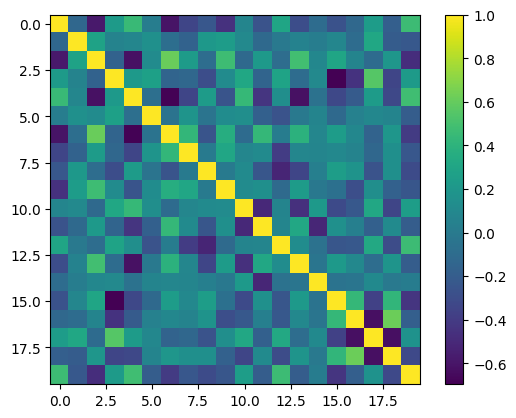

In [6]:
similarity_matrix = np.corrcoef(temporal_comps.T)
plt.imshow(similarity_matrix)
plt.colorbar()

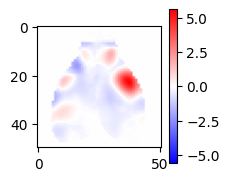

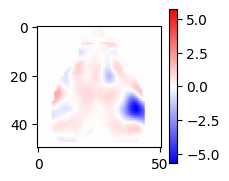

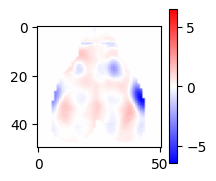

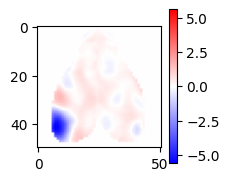

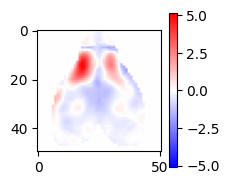

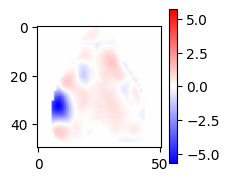

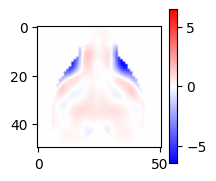

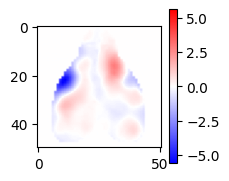

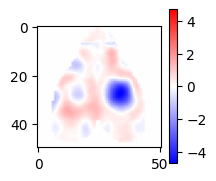

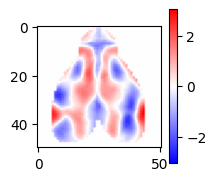

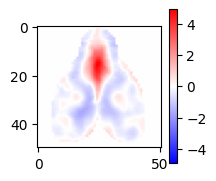

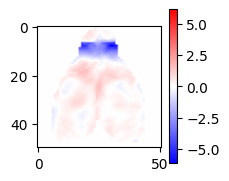

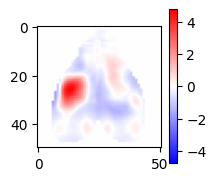

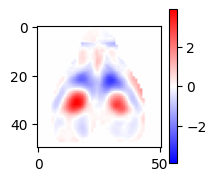

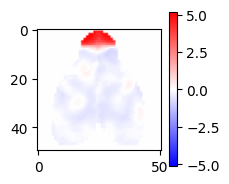

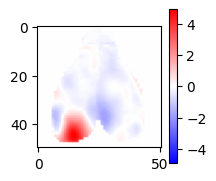

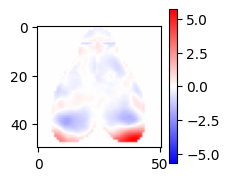

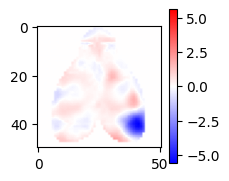

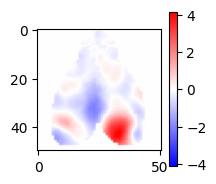

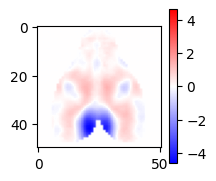

In [7]:
# let's visualize the 15 spatial components

for i,centroid in enumerate(spatial_comps.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
    fig.set_size_inches(2,2)

In [9]:
# create mega array with walking for each mouse in order to do clustering during walk

walking_all = np.array([])  # Initialize an empty array for concatenation

for name in names + names_knock:
    walking = np.load('/home/k21208334/calcium_analyses/data/walking/' + name + '.npy')
    walking_all = np.concatenate((walking_all, walking), axis=0)

In [37]:
# I do clustering only with the walking data to see what happens
from sklearn.cluster import KMeans
k = 7

km_walking = KMeans(n_clusters=k)
km_walking = km_walking.fit(temporal_comps[walking_all>0,:])

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


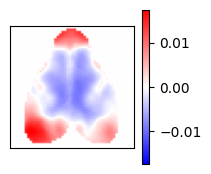

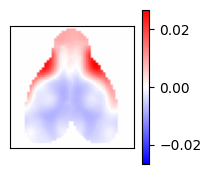

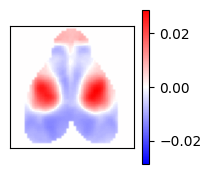

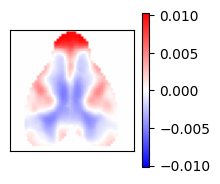

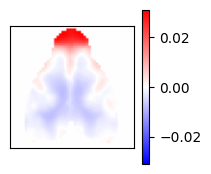

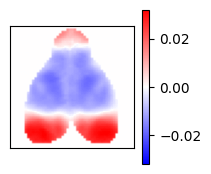

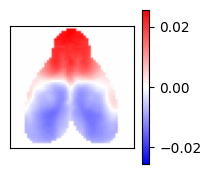

In [39]:
cluster_centers = km_walking.cluster_centers_
centroids = np.dot(spatial_comps,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
    fig.set_size_inches(2,2)
    plt.xticks([])
    plt.yticks([])

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def do_statistics_wild_ko(centroids,H,W,good_indices,measure,title):

    for i,centroid in enumerate(centroids.T):
        fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
        fig.set_size_inches(2,2)
        plt.xticks([])
        plt.yticks([])
    
        fig,ax = plt.subplots()
        fig.set_size_inches(6,2)
        ax.boxplot([measure[0:6,i],measure[6:12,i]])
        test = mannwhitneyu(measure[0:6,i],measure[6:12,i])
        pvalue1 = test.pvalue
        ax.set_xticks([1,2], ['wild','KO'])
        ax.set_title('p=, '+str(round(pvalue1,3)),fontsize=10)
        ax.set_ylabel(title)


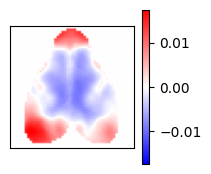

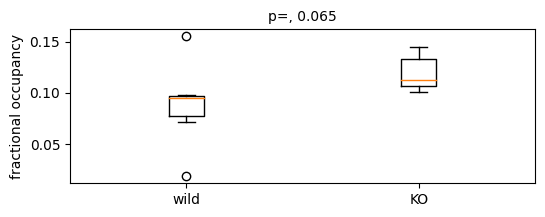

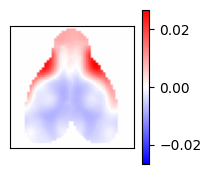

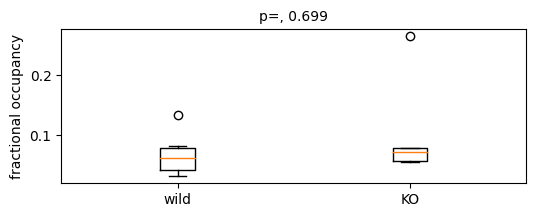

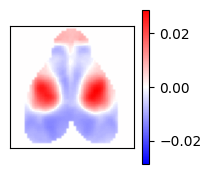

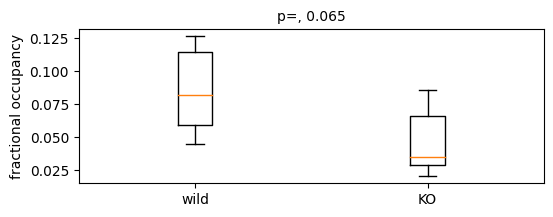

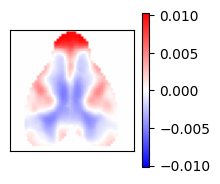

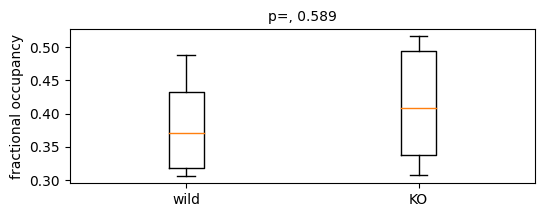

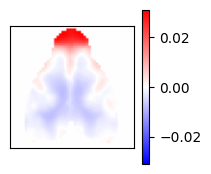

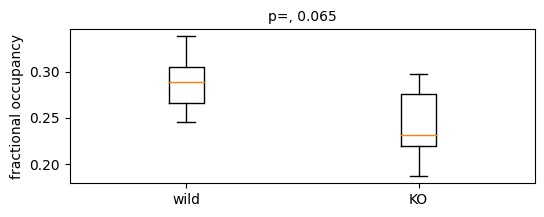

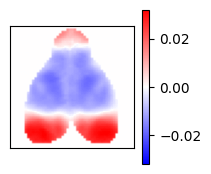

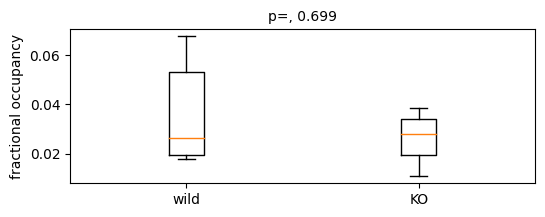

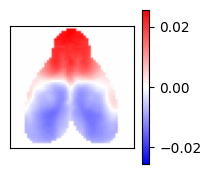

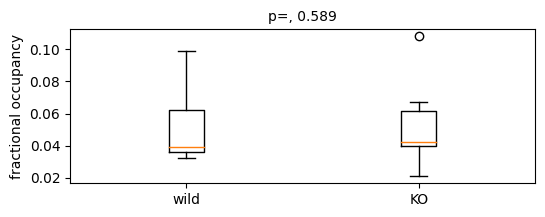

In [41]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

# ripartire DA QUA CAPIRE COSA CAZZO NON FUNZIONA!

n_individuals = len(names+names_knock)
fractional_occupancies = np.zeros((n_individuals,k))

summ = 0

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km_walking.labels_[int(summ):int(summ+np.sum(walking))]==j
        fractional_occupancies[i,j] = np.sum(timeseries_labels)/len(timeseries_labels)
    summ = summ +np.sum(walking)
    
do_statistics_wild_ko(centroids,H,W,good_indices,fractional_occupancies,'fractional occupancy')

/home/k21208334/calcium_analyses/calcium_dynamics/analyze/../dFC/connectivity_measures.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


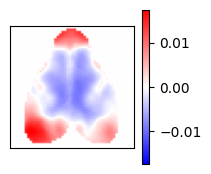

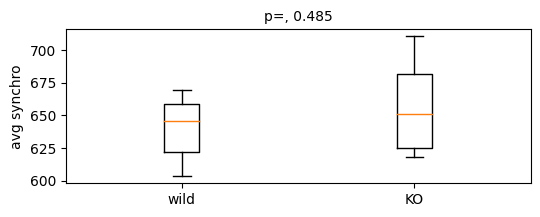

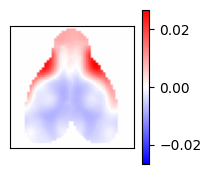

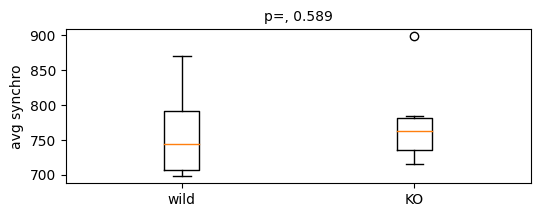

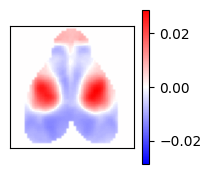

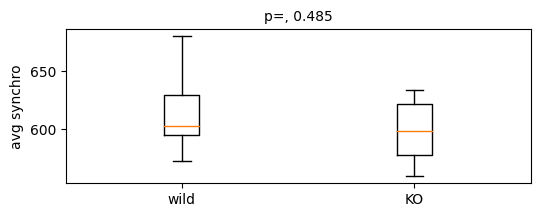

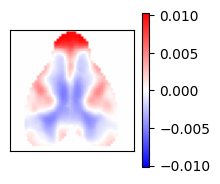

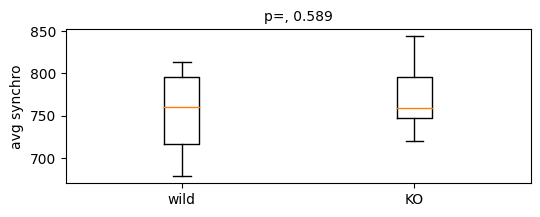

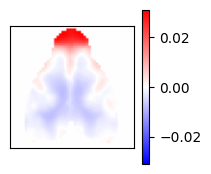

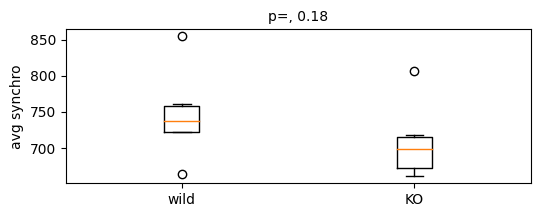

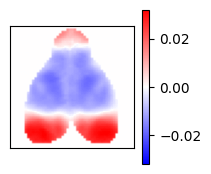

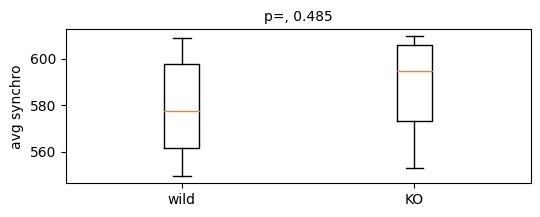

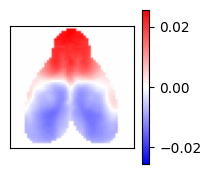

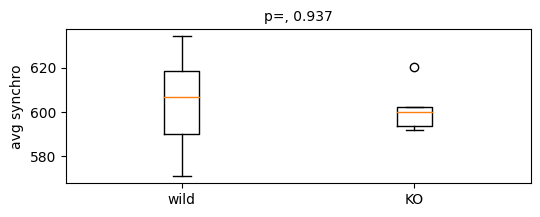

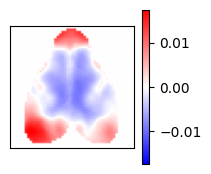

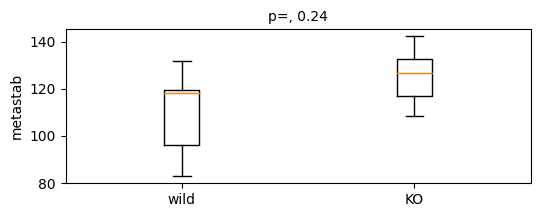

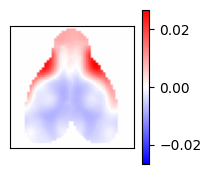

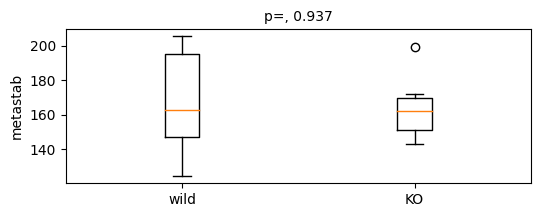

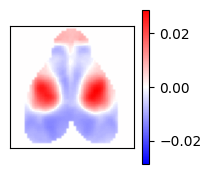

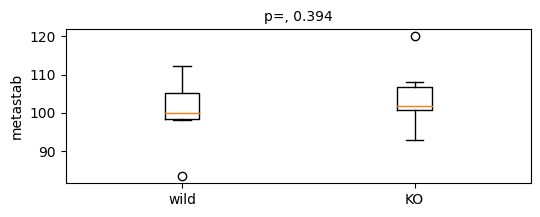

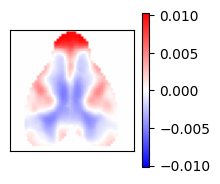

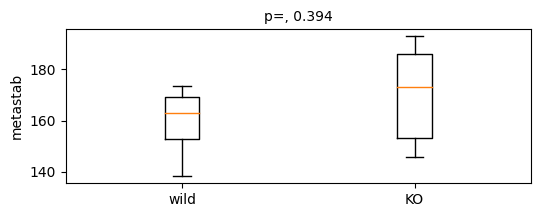

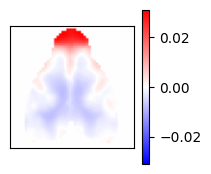

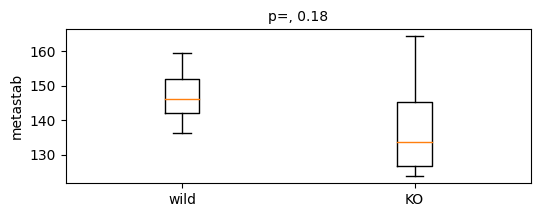

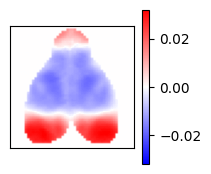

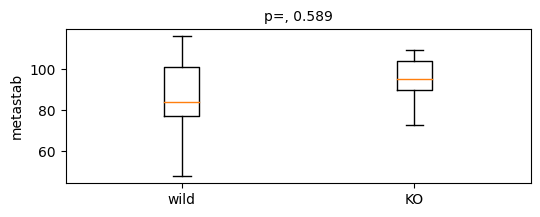

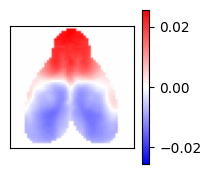

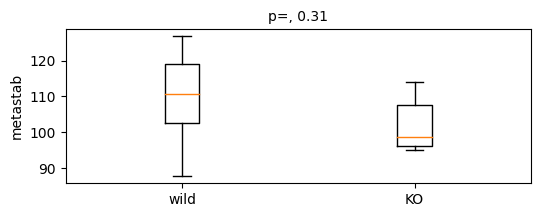

In [42]:
# let us  do average synchro and metastability

n_individuals = len(names+names_knock)
synchro = np.zeros((n_individuals,k))
meta = np.zeros((n_individuals,k))

summ = 0


for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        timeseries_labels = km_walking.labels_[int(summ):int(summ+np.sum(walking))]==j
        eig_timeseries = np.load(path+name+'_eigenvalue_timeseries.npy')
        eig_timeseries = eig_timeseries[walking] # i take only when it's walking
        
        synchro[i,j] = np.mean(eig_timeseries[timeseries_labels])
        meta[i,j] = np.std(eig_timeseries[timeseries_labels])
    summ = summ +np.sum(walking)


do_statistics_wild_ko(centroids,H,W,good_indices,synchro,'avg synchro')
do_statistics_wild_ko(centroids,H,W,good_indices,meta,'metastab')

# same analysis with rest 

/home/k21208334/.conda/envs/calcium_analyses/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


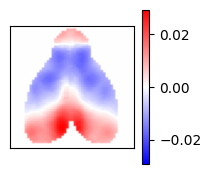

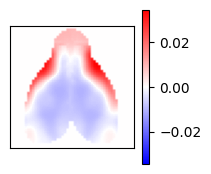

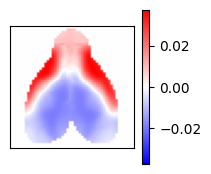

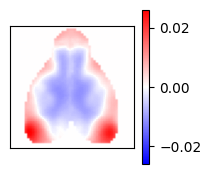

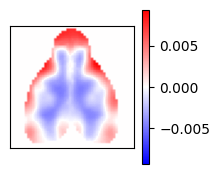

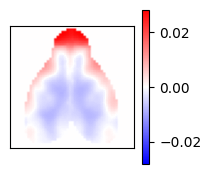

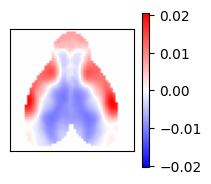

In [38]:
# do same with rest

# I do clustering only with the walking data to see what happens
from sklearn.cluster import KMeans
k = 7

km_rest = KMeans(n_clusters=k)
km_rest = km.fit(temporal_comps[walking_all<1,:])

cluster_centers = km_rest.cluster_centers_
centroids = np.dot(spatial_comps,cluster_centers.T)

for i,centroid in enumerate(centroids.T):
    fig = connectivity_measures.show_array(centroid,H,W,good_indices,(-np.abs(centroid).max(),np.abs(centroid).max()))
    fig.set_size_inches(2,2)
    plt.xticks([])
    plt.yticks([])
    
    


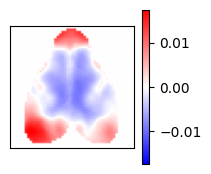

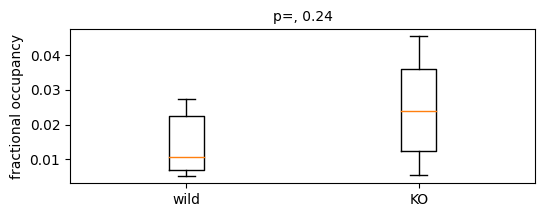

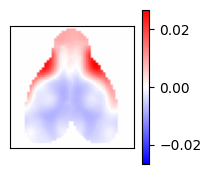

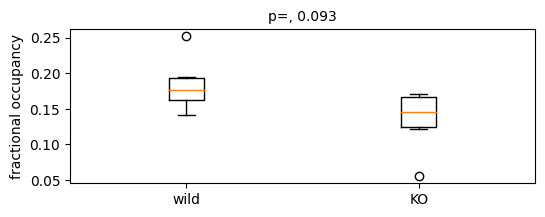

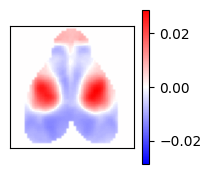

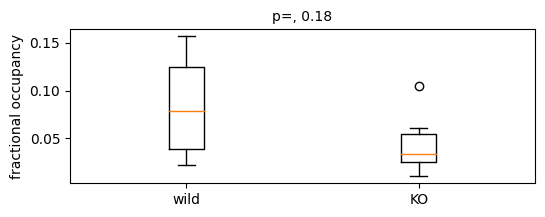

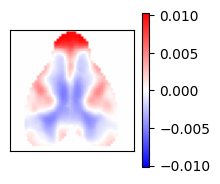

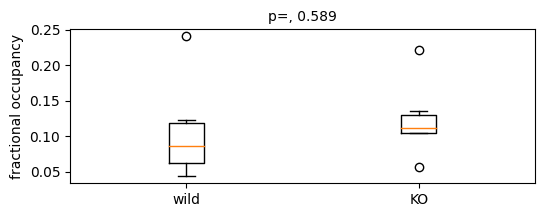

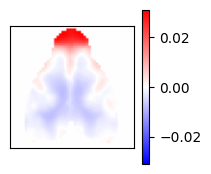

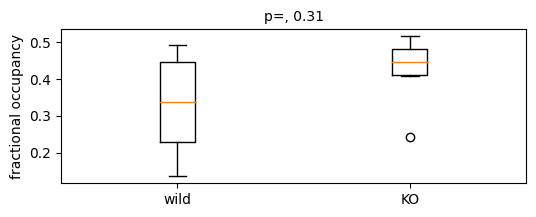

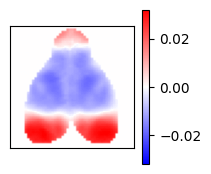

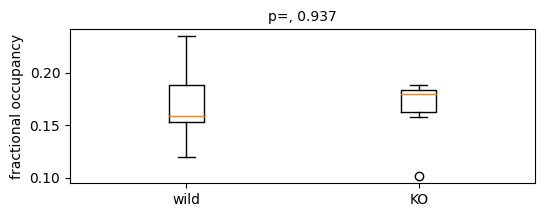

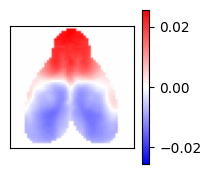

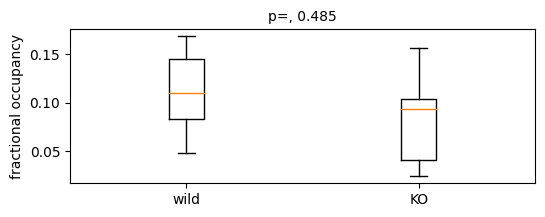

In [43]:
# let's define fractional occupancies. REALITY is just a dream which is good enough to make us survive.

# ripartire DA QUA CAPIRE COSA CAZZO NON FUNZIONA!

n_individuals = len(names+names_knock)
fractional_occupancies = np.zeros((n_individuals,k))

summ = 0

for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        walking = walking==0
        timeseries_labels = km_rest.labels_[int(summ):int(summ+np.sum(walking))]==j
        fractional_occupancies[i,j] = np.sum(timeseries_labels)/len(timeseries_labels)
    summ = summ +np.sum(walking)
    
do_statistics_wild_ko(centroids,H,W,good_indices,fractional_occupancies,'fractional occupancy')

/home/k21208334/calcium_analyses/calcium_dynamics/analyze/../dFC/connectivity_measures.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


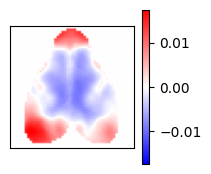

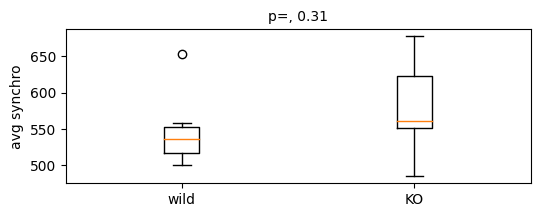

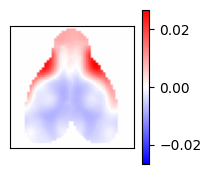

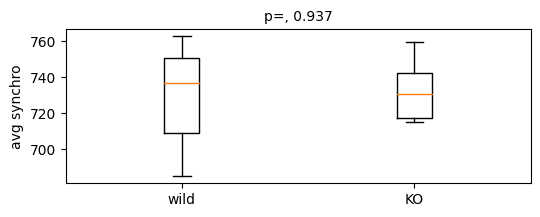

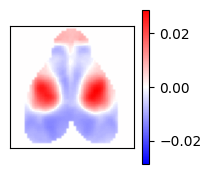

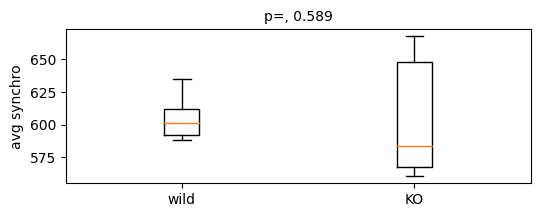

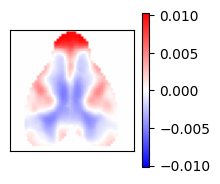

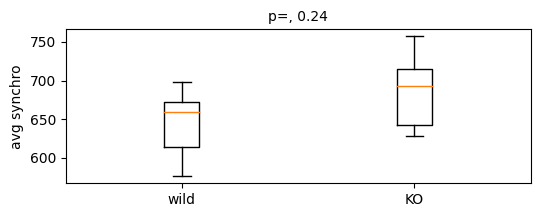

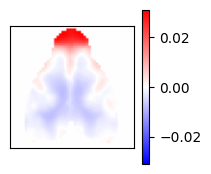

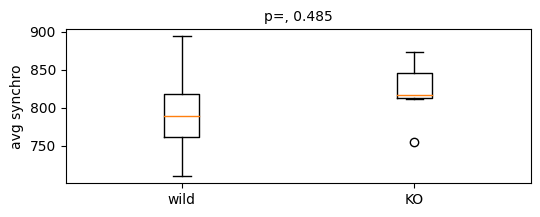

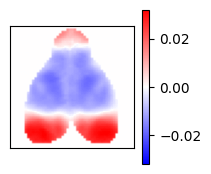

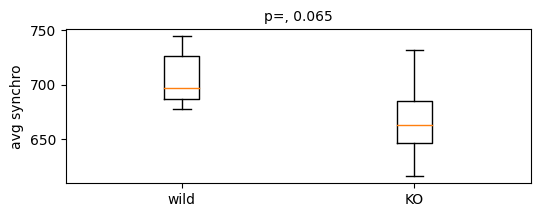

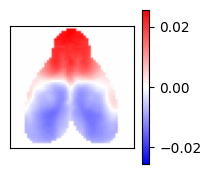

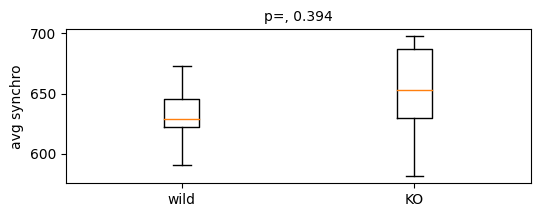

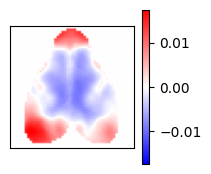

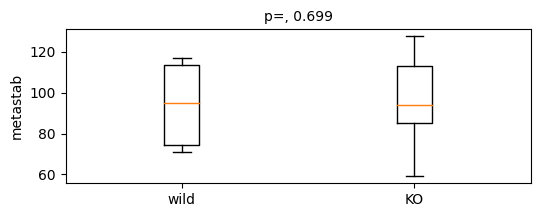

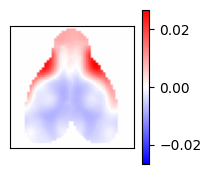

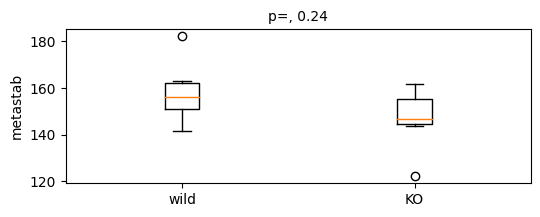

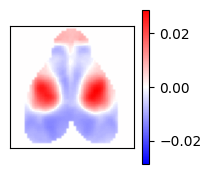

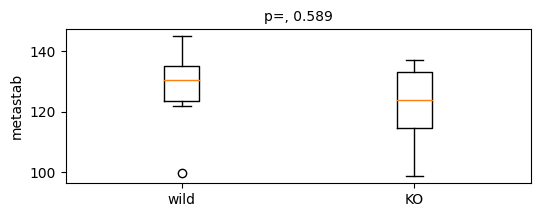

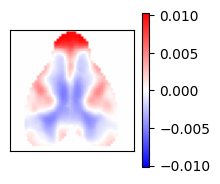

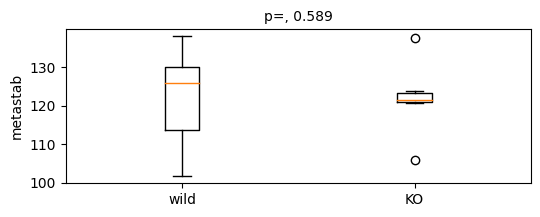

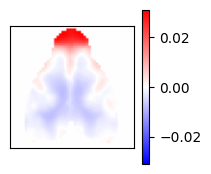

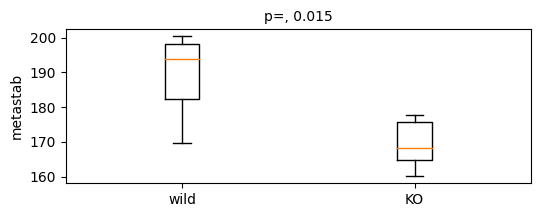

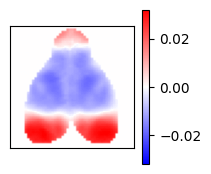

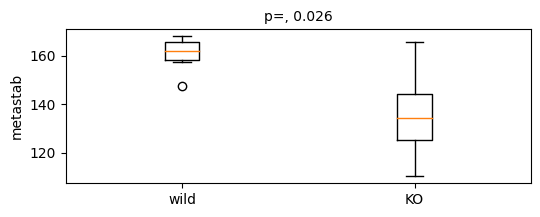

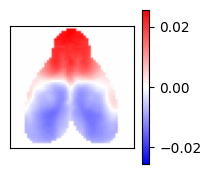

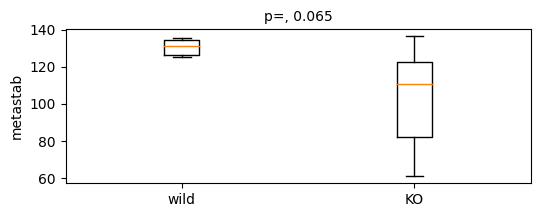

In [44]:
# let us  do average synchro and metastability

n_individuals = len(names+names_knock)
synchro = np.zeros((n_individuals,k))
meta = np.zeros((n_individuals,k))

summ = 0


for i,name in enumerate(names+names_knock):
    for j in range(k):
        walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
        walking = walking==0
        timeseries_labels = km.labels_[int(summ):int(summ+np.sum(walking))]==j
        eig_timeseries = np.load(path+name+'_eigenvalue_timeseries.npy')
        eig_timeseries = eig_timeseries[walking] # i take only when it's walking
        
        synchro[i,j] = np.mean(eig_timeseries[timeseries_labels])
        meta[i,j] = np.std(eig_timeseries[timeseries_labels])
    summ = summ +np.sum(walking)


do_statistics_wild_ko(centroids,H,W,good_indices,synchro,'avg synchro')
do_statistics_wild_ko(centroids,H,W,good_indices,meta,'metastab')